# Ensemble Methods: Random Forests and Boosting

BUSMGT 7247

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (accuracy_score, precision_score,
                             recall_score, f1_score, confusion_matrix,
                             mean_squared_error, r2_score)
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.ensemble import (BaggingClassifier, VotingClassifier,
                              RandomForestClassifier, ExtraTreesClassifier,
                              AdaBoostClassifier, GradientBoostingClassifier)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from xgboost import XGBClassifier, XGBRegressor

# Options for plots
%matplotlib inline
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Seed the random number generator for reproducible results
random_state = 1000
np.random.seed(random_state)

In [2]:
def plot_decision_boundary(
    clf, X, y, classes, features, xlims,
    markers=['<', 'o', 's'],
    markercolors=['darkgreen', 'navy', 'darkred'],
    fillcolors=['lightgreen', 'cornflowerblue', 'lightcoral'],
    steps=1000, alpha=0.2, figsize=(15, 6)
):
    x1, x2 = np.meshgrid (np.linspace(*xlims[0], steps).reshape(-1, 1),
                          np.linspace(*xlims[1], steps).reshape(-1, 1))
    
    X_bound = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_bound)
    z = LabelEncoder().fit_transform(y_pred).reshape(x1.shape)
    
    plt.figure(figsize=figsize)
    
    for i, c in enumerate(classes):
        plt.plot(X.loc[y == c, features[0]], X.loc[y == c, features[1]],
                 color=markercolors[i], marker=markers[i],
                 linestyle='none', label=c)
    
    plt.contourf(x1, x2, z, levels=len(classes) + 1,
                 alpha=alpha, cmap=ListedColormap(fillcolors))
   
    plt.xlabel(features[0])
    plt.ylabel(features[1])
    plt.legend()
    plt.show()

## Load Data

### Data Description

The Bureau of Labor Statistics administers a National Longitudinal Survey of Youth that tracks individuals over the course of their lives.

The 1979 (NLSY79) cohort includes men and women born in the USA between 1957 and 1964.

In the data set, each row represents an individual that participates in the 1979 cohort.

| Attribute      | Definition                                                                                   |
| -------------- | -------------------------------------------------------------------------------------------- |
| ID             | Participant identifier assigned by BLS                                                       |
| Earnings       | Annual wage earnings 2014                                                                    |
| WeeksWorked    | Count of weeks worked in 2014                                                                |
| CumWeeksWorked | Cumulative weeks of work experience during study                                             |
| Education      | Years of education as of 2014                                                                |
| IQ             | Percentile on IQ test taken in 1979                                                          |
| Gender         | Participant's gender                                                                         |
| MSA            | Did the participant reside within an urban cluster or urbanized area in 2014?                |
| Library        | Did the participant, or someone in the participant's household, have a library card in 1979? |
| Esteem         | Score on the Rosenberg Self-Esteem Scale in 1979                                             |

In [3]:
df = pd.read_csv('data/nlsy.csv')
df.head()

,ID,Earnings,WeeksWorked,CumWeeksWorked,Education,IQ,Gender,MSA,Library,Esteem
0,83,0,3,553.0,10,2,Male,Yes,Yes,18
1,84,0,3,107.0,12,9,Male,Yes,Yes,20
2,87,11500,5,759.0,12,5,Male,Yes,Yes,22
3,105,20501,11,979.0,12,84,Female,Yes,Yes,19
4,178,59000,46,1010.0,16,99,Male,No,Yes,24


## Simple Ensemble

In [4]:
# Return index of education category as a function of years of education
def education_category(years_education):
    if years_education < 16:
        return 'High School'
    elif years_education == 16:
        return 'Undergraduate'
    else:
        return 'Graduate'


# Create a variable to contain each participant's education category    
df['EducationCategory'] = df['Education'].apply(education_category)
df['EducationCategory'].value_counts(normalize=True)

High School      0.830679
Undergraduate    0.113160
Graduate         0.056161
Name: EducationCategory, dtype: float64

In [5]:
# Predict EducationCategory as a function of Earnings and WeeksWorked
X = df[['Earnings', 'WeeksWorked']]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.25,
                                     stratify=y, random_state=random_state)

In [6]:
# Use logistic regression, decision tree, and k-nearest neighbors classifiers
log_clf = LogisticRegression(multi_class='multinomial', solver='lbfgs', 
                             random_state=random_state)
tree_clf = DecisionTreeClassifier(max_depth=3, random_state=random_state)
knn_clf = KNeighborsClassifier(n_neighbors=4)

voting_clf = VotingClassifier(
    estimators=[('logreg', log_clf), ('tree', tree_clf),
                ('knn', knn_clf)],
    voting='soft'
)

In [7]:
# Evaluate voting classifier on the training data
voting_clf.fit(X_train, y_train)
y_pred = voting_clf.predict(X_test)
print(f'Voting classifier accuracy: {accuracy_score(y_test, y_pred):.3f}')

Voting classifier accuracy: 0.903


In [8]:
for clf in voting_clf.estimators_:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print('{:<24} {:.3f}'.format(clf.__class__.__name__,
                                 accuracy_score(y_test, y_pred)))

LogisticRegression       0.749
DecisionTreeClassifier   0.893
KNeighborsClassifier     0.890


In [9]:
# Fit the voting classifier
voting_clf.fit(X_train, y_train)

idx = 1
instance = X_test.iloc[idx, :].to_numpy().reshape(1, -1)

print('{:<40} {:>16}\n'.format('Actual', y_test.iloc[idx]))
print('{:<40} {:>16}\n'.format('Voting classifier prediction',
                             voting_clf.predict(instance)[0]))

for clf in voting_clf.estimators_:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(instance)
    print('{:<40} {:>16}'.format(clf.__class__.__name__ + ' prediction',
                                 y_pred[0]))

Actual                                      Undergraduate

Voting classifier prediction                Undergraduate

LogisticRegression prediction               Undergraduate
DecisionTreeClassifier prediction           Undergraduate
KNeighborsClassifier prediction                  Graduate


### Exercise
Add the remaining variables to the voting classifier and observe how accuracy changes. Keep in mind that you may need to change the arguments for the constituent classifiers (e.g., max_iter for LogisticRegression).

## Bagging and Pasting

In [10]:
# Fit a bagging classifier using decision trees
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=random_state, max_depth=6),
    n_estimators=1000, max_samples=500, bootstrap=True,
    random_state=random_state
)
bag_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = bag_clf.predict(X_test)
print(f'Bagging classifier accuracy: {accuracy_score(y_test, y_pred):.3f}')

Bagging classifier accuracy: 0.910


In [11]:
# Compare the bagging classifier to a single decision tree fit to the
# full training data set
tree_clf = DecisionTreeClassifier(max_depth=6, random_state=random_state)
tree_clf.fit(X_train, y_train)

y_pred = tree_clf.predict(X_test)
print(f'Decision tree classifier accuracy: {accuracy_score(y_test, y_pred):.3f}')

Decision tree classifier accuracy: 0.900


### Exercise
How do the bagging classifier and the single decision tree compare when we add the CumWeeksWorked variable?

## Random Forests

In [12]:
# Predict EducationCategory as a function of Earnings,
# WeeksWorked, and CumWeeksWorked
feature_vars = ['Earnings', 'WeeksWorked', 'CumWeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.25,
                                     stratify=y, random_state=random_state)

In [13]:
# Use cross validation to pick the number of trees (estimators)
# and the max depth of the trees
search_parameters = {
    'n_estimators':range(100, 400, 100),
    'max_depth':range(6, 12)
}

rnd_clf = RandomForestClassifier(n_jobs=3, random_state=random_state) 
grid_clf = GridSearchCV(rnd_clf, search_parameters)
grid_clf.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestClassifier(n_jobs=3, random_state=1000),
             param_grid={'max_depth': range(6, 12),
                         'n_estimators': range(100, 400, 100)})

In [14]:
print(f'Accuracy: {grid_clf.best_score_:.3f}')
grid_clf.best_params_

Accuracy: 0.918


{'max_depth': 8, 'n_estimators': 200}

In [15]:
# Get the best classifier from GridSearchCV
best_clf = grid_clf.best_estimator_

# Get accuracy on the test data
y_pred = best_clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}\n')

# Get feature importances
for name, imp in zip(feature_vars, best_clf.feature_importances_):
    print('{:<16} {:.3f}'.format(name, imp))

Accuracy: 0.913

Earnings         0.704
WeeksWorked      0.128
CumWeeksWorked   0.168


## Exercise
Use GridSearchCV to optimize hyperparameters other than n_estimators and max_depth.

In [16]:
# Fit an ensemble of extremely randomized trees
ext_clf = ExtraTreesClassifier(max_depth=10, n_estimators=100,
                               random_state=random_state)
ext_clf.fit(X_train, y_train)

# Get accuracy on the test data
y_pred = ext_clf.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred):.3f}\n')

# Get feature importances
for name, imp in zip(feature_vars, ext_clf.feature_importances_):
    print('{:<16} {:.3f}'.format(name, imp))

Accuracy: 0.910

Earnings         0.738
WeeksWorked      0.126
CumWeeksWorked   0.136


## AdaBoost

In [17]:
# Predict EducationCategory as a function of Earnings and WeeksWorked
feature_vars = ['Earnings', 'WeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.25,
                                     stratify=y, random_state=random_state)

In [18]:
# Fit AdaBoost classifier
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=6),
    n_estimators=400,
    random_state=random_state
)
ada_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = ada_clf.predict(X_test)
print(f'{accuracy_score(y_test, y_pred):.3f}')

0.890


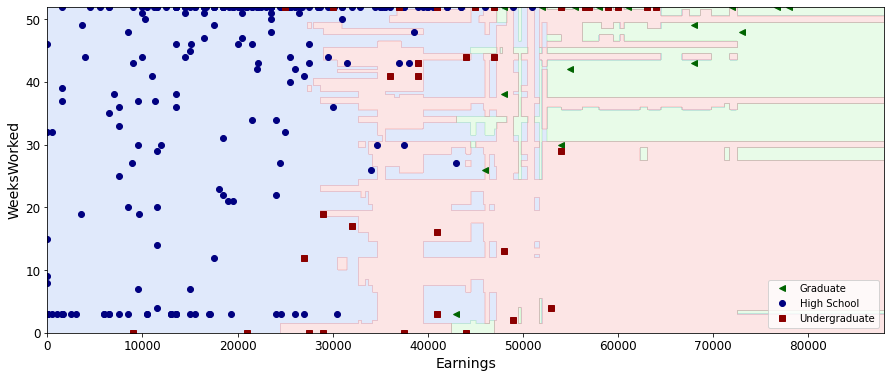

In [19]:
# Visualize decision boundaries
xlims = [
    [df['Earnings'].min(), df['Earnings'].max()],
    [df['WeeksWorked'].min(), df['WeeksWorked'].max()]
]

plot_decision_boundary(ada_clf, X_test, y_test,
                       classes=['Graduate', 'High School', 'Undergraduate'],
                       features=feature_vars,
                       xlims=xlims)     

In [20]:
# Predict EducationCategory as a function of Earnings,
# WeeksWorked, and CumWeeksWorked
feature_vars = ['Earnings', 'WeeksWorked', 'CumWeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.25,
                                     stratify=y, random_state=random_state)

In [21]:
ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=8),
    n_estimators=400,
    random_state=random_state
)
ada_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = ada_clf.predict(X_test)
print(f'{accuracy_score(y_test, y_pred):.3f}')

0.920


### Exercise
Experiment with the AdaBoost learning rate (learning_rate) using cross-validation.

## Gradient Boosting

In [22]:
# Predict EducationCategory as a function of Earnings and WeeksWorked
feature_vars = ['Earnings', 'WeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.25,
                                     stratify=y, random_state=random_state)

In [23]:
# Fit Gradient Boosting classifier
grb_clf = GradientBoostingClassifier(random_state=random_state)
grb_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = grb_clf.predict(X_test)
print(f'{accuracy_score(y_test, y_pred):.3f}')

0.900


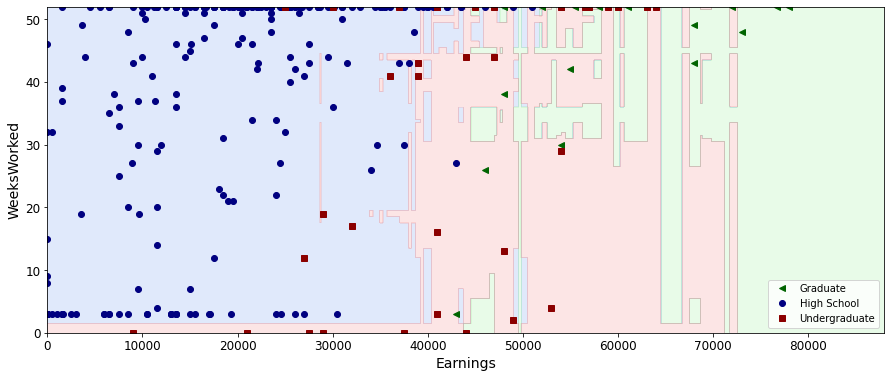

In [24]:
# Visualize decision boundaries
xlims = [
    [df['Earnings'].min(), df['Earnings'].max()],
    [df['WeeksWorked'].min(), df['WeeksWorked'].max()]
]

plot_decision_boundary(grb_clf, X_test, y_test,
                       classes=['Graduate', 'High School', 'Undergraduate'],
                       features=feature_vars,
                       xlims=xlims)     

In [25]:
# Predict EducationCategory as a function of Earnings,
# WeeksWorked, and CumWeeksWorked
feature_vars = ['Earnings', 'WeeksWorked', 'CumWeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.25,
                                     stratify=y, random_state=random_state)

In [26]:
# Fit Gradient Boosting classifier
grb_clf = GradientBoostingClassifier(random_state=random_state)
grb_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = grb_clf.predict(X_test)
print(f'{accuracy_score(y_test, y_pred):.3f}')

0.906


### Exercise
Build a better gradient boosting model by experimenting with cross-validation for hyperparameter optimization.

## XGBoost

In [27]:
# Predict EducationCategory as a function of Earnings,
# WeeksWorked, and CumWeeksWorked
feature_vars = ['Earnings', 'WeeksWorked', 'CumWeeksWorked']
X = df[feature_vars]
y = df['EducationCategory']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.25,
                                     stratify=y, random_state=random_state)

In [28]:
# Fit Gradient Boosting classifier
xgb_clf = XGBClassifier(random_state=random_state)
xgb_clf.fit(X_train, y_train)

# Evaluate on the test data
y_pred = xgb_clf.predict(X_test)
print(f'{accuracy_score(y_test, y_pred):.3f}')

[09:43:16] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
0.913


/Users/ncraig/envs/curr/lib/python3.9/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


## XGBoost: Store Closings, Regression Example

### Data Description

When retailers close stores, they usually conduct going-out-of-business (GOB) sales.

In the data set, each row represents a store's going out of business sale.

| Attribute             | Definition                                                                |
| --------------------- | ------------------------------------------------------------------------- |
| StoreType             | Store's retail segment (bookstores or household goods)                    |
| LiquidationRevenue    | Revenue from the GOB sale                                                 |
| InventoryAtTicket     | Retail value of inventory held at the start of the GOB sale               |
| LastYearRevenue       | Store's revenue over the GOB sale dates during the prior year             |                      
| MedianHouseholdIncome | Median household income in the store's ZIP code (from U.S. Census Bureau) |
| MedianAge             | Median age in the store's ZIP code (from U.S. Census Bureau)              |

In [29]:
df = pd.read_csv('data/closings.csv')
df.head()

,StoreType,LiquidationRevenue,InventoryAtTicket,LastYearRevenue,MedianHouseholdIncome,MedianAge
0,Bookstore,1214776.2,2195069.8,465237.3,51290,37.8
1,Bookstore,1811896.9,3152301.9,897704.5,46702,33.4
2,Bookstore,1157614.7,2229837.5,477804.8,86804,41.7
3,Bookstore,2037136.2,3857466.8,1036097.7,83544,40.3
4,Bookstore,1326821.1,2345263.8,612793.5,23508,31.9


In [30]:
# Predict LiquidationRevenue as a function of all available variables
df['Bookstore'] = df['StoreType'].map(lambda x: 1 if x == 'Bookstore' else 0)
feature_vars = ['Bookstore', 'InventoryAtTicket', 'LastYearRevenue',
                'MedianHouseholdIncome', 'MedianAge']
X = df[feature_vars]
y = df['LiquidationRevenue']

# Split data into training and testing sets
(X_train, X_test, 
 y_train, y_test) = train_test_split(X, y, test_size=0.2,
                                     stratify=df['StoreType'],
                                     random_state=random_state)

In [31]:
# Use cross-validation to optimize the learning rate
search_parameters = {
    'learning_rate':np.arange(0.01, 0.15, 0.01)
}

xgb_reg = XGBRegressor(random_state=random_state)
grid_reg = GridSearchCV(xgb_reg, search_parameters)
grid_reg.fit(X_train, y_train)

print(f'Best learning rate: {grid_reg.best_params_["learning_rate"]:.3f}')

Best learning rate: 0.110


In [32]:
# Get the best-performing classifier
best_xgb_reg = grid_reg.best_estimator_

# Calculate performance on training data
y_pred = best_xgb_reg.predict(X_train)
mse = mean_squared_error(y_train, y_pred)
rmse = np.sqrt(mse)
print(f'Train MSE:  {mse:.3f}\n'
      f'Train RMSE: {rmse:.3f}\n'
      f'Train R2:   {r2_score(y_train, y_pred):.3f}\n')

# Calculate performance on test data
y_pred = best_xgb_reg.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f'Test MSE:   {mse:.3f}\n'
      f'Test RMSE:  {rmse:.3f}\n'
      f'Test R2:    {r2_score(y_test, y_pred):.3f}')

Train MSE:  1831985307.564
Train RMSE: 42801.697
Train R2:   0.995

Test MSE:   36407209960.911
Test RMSE:  190806.735
Test R2:    0.924
